# SPAM Detection

### Installations and Imports

In [47]:
%pip install numpy pandas tensorflow matplotlib seaborn nltk scikit-learn wordcloud

# Importing necessary libraries for EDA
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import string
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud
nltk.download('stopwords')

# Importing libraries necessary for Model Building and Training
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

import warnings
warnings.filterwarnings('ignore')


Note: you may need to restart the kernel to use updated packages.


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\popsi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Load Data and make columns uniform

In [48]:
# Load 'lingSpam'
df_ling = pd.read_csv('data\lingSpam.csv')

# Load 'enronSpamSubset'
df_enron = pd.read_csv('data\enronSpamSubset.csv')

# Load 'completeSpamAssassin' 
df_sa = pd.read_csv('data\completeSpamAssassin.csv')

# check columns in dataframes
print(df_ling.columns)
print(df_enron.columns)
print(df_sa.columns)

# remove extra column from enron data
df_enron = df_enron.drop(columns=['Unnamed: 0.1'])
print('Removing exta column...')
print(df_ling.columns)
print(df_enron.columns)
print(df_sa.columns)

df_enron.head()


Index(['Unnamed: 0', 'Body', 'Label'], dtype='object')
Index(['Unnamed: 0.1', 'Unnamed: 0', 'Body', 'Label'], dtype='object')
Index(['Unnamed: 0', 'Body', 'Label'], dtype='object')
Removing exta column...
Index(['Unnamed: 0', 'Body', 'Label'], dtype='object')
Index(['Unnamed: 0', 'Body', 'Label'], dtype='object')
Index(['Unnamed: 0', 'Body', 'Label'], dtype='object')


,Unnamed: 0,Body,Label
0,2469,Subject: stock promo mover : cwtd\n * * * urge...,1
1,5063,Subject: are you listed in major search engine...,1
2,12564,"Subject: important information thu , 30 jun 20...",1
3,2796,Subject: = ? utf - 8 ? q ? bask your life with...,1
4,1468,"Subject: "" bidstogo "" is places to go , things...",1


### Try working with smallest dataset, Spam Assassin, first
Check for data imbalance

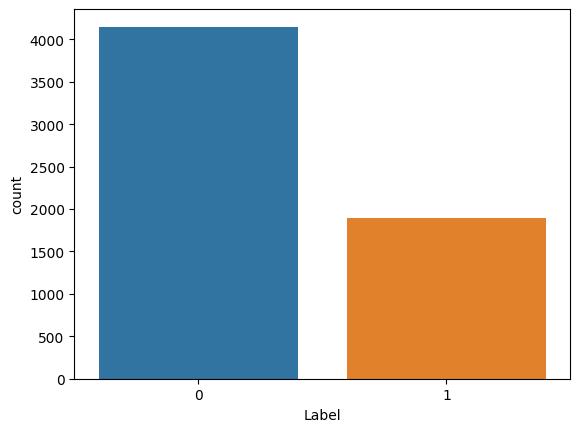

In [49]:
sns.countplot(x='Label', data=df_sa)
plt.show()

Ratio of ~ 2:1, not imbalanced enough to require over or under sampling

### Clean up unneeded words and punctuation

In [50]:
# remove blanks
df_sa = df_sa.dropna()

#  remove the word "Subject" from every email

df_sa['Body'] = df_sa['Body'].str.replace('Subject', '')

# remove punctuation
punctuations_list = string.punctuation
def remove_punctuations(text):
    temp = str.maketrans('', '', punctuations_list)
    return text.translate(temp)
 
df_sa['Body']= df_sa['Body'].apply(lambda x: remove_punctuations(x))

# remove "stopwords"
def remove_stopwords(text):
	stop_words = stopwords.words('english')

	imp_words = []

	# Storing the important words
	for word in str(text).split():
		word = word.lower()

		if word not in stop_words:
			imp_words.append(word)

	output = " ".join(imp_words)

	return output


df_sa['Body'] = df_sa['Body'].apply(lambda text: remove_stopwords(text))
df_sa.head()


# check cleanup results
df_sa.head()


,Unnamed: 0,Body,Label
0,0,save 70 life insurance spend tolife quote savi...,1
1,1,1 fight risk cancer httpwwwadclickwspcfmo315sp...,1
2,2,1 fight risk cancer httpwwwadclickwspcfmo315sp...,1
3,3,adult club offers free membership instant acce...,1
4,4,thought might like 1 slim guaranteed lose 1012...,1


### Make wordclouds

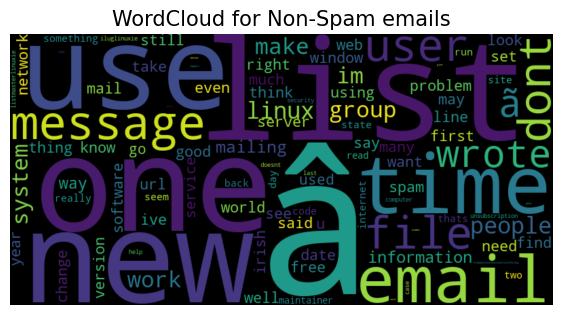

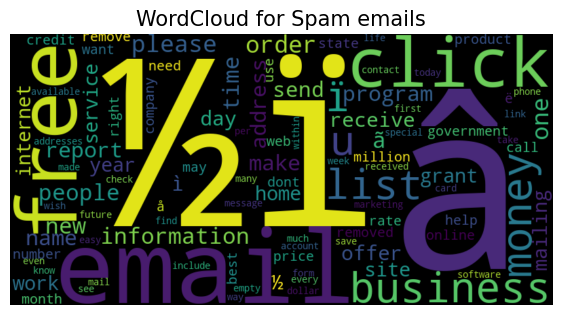

In [51]:
def plot_word_cloud(data, typ):
    email_corpus = " ".join(data['Body'])
 
    plt.figure(figsize=(7, 7))
 
    wc = WordCloud(background_color='black',
                   max_words=100,
                   width=800,
                   height=400,
                   collocations=False).generate(email_corpus)
 
    plt.imshow(wc, interpolation='bilinear')
    plt.title(f'WordCloud for {typ} emails', fontsize=15)
    plt.axis('off')
    plt.show()
 
plot_word_cloud(df_sa[df_sa['Label'] == 0], typ='Non-Spam')
plot_word_cloud(df_sa[df_sa['Label'] == 1], typ='Spam')

### Split Data

In [52]:
#train test split
X_train, X_test, Y_train, Y_test = train_test_split(df_sa['Body'],
													df_sa['Label'],
													test_size = 0.2,
													random_state = 42)


### Tokenize text

In [53]:
# Tokenize the text data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

# Convert text to sequences
train_sequences = tokenizer.texts_to_sequences(X_train)
test_sequences = tokenizer.texts_to_sequences(X_test)

# Pad sequences to have the same length
max_len = 100 # maximum sequence length
train_sequences = pad_sequences(train_sequences,
								maxlen=max_len,
								padding='post',
								truncating='post')
test_sequences = pad_sequences(test_sequences,
							maxlen=max_len,
							padding='post',
							truncating='post')


### Create model

In [60]:

# Build the model
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Embedding(input_dim=len(tokenizer.word_index) + 1,
                                    output_dim=32,
                                    input_length=max_len))
model.add(tf.keras.layers.LSTM(16))
model.add(tf.keras.layers.Dense(32, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
 
# Print the model summary
model.summary()

model.compile(loss = tf.keras.losses.BinaryCrossentropy(from_logits = True),
              metrics = ['accuracy'],
              optimizer = 'adam')

es = EarlyStopping(patience=10,
				monitor = 'val_accuracy',
				restore_best_weights = True)

lr = ReduceLROnPlateau(patience = 2,
					monitor = 'val_loss',
					factor = 0.5,
					verbose = 0)


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 100, 32)           2410464   
                                                                 
 lstm_2 (LSTM)               (None, 16)                3136      
                                                                 
 dense_4 (Dense)             (None, 32)                544       
                                                                 
 dense_5 (Dense)             (None, 1)                 33        
                                                                 
Total params: 2414177 (9.21 MB)
Trainable params: 2414177 (9.21 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### Train Model

In [61]:
# Train the model
history = model.fit(train_sequences, Y_train,
					validation_data=(test_sequences, Y_test),
					epochs=20,
					batch_size=32,
					callbacks = [lr, es]
				)


Epoch 1/20
152/152 [==============================] - 9s 44ms/step - loss: 0.5374 - accuracy: 0.7469 - val_loss: 0.2421 - val_accuracy: 0.9173 - lr: 0.0010
Epoch 2/20
152/152 [==============================] - 6s 40ms/step - loss: 0.2606 - accuracy: 0.8902 - val_loss: 0.2228 - val_accuracy: 0.9413 - lr: 0.0010
Epoch 3/20
152/152 [==============================] - 6s 40ms/step - loss: 0.1449 - accuracy: 0.9543 - val_loss: 0.1636 - val_accuracy: 0.9487 - lr: 0.0010
Epoch 4/20
152/152 [==============================] - 6s 39ms/step - loss: 0.1143 - accuracy: 0.9626 - val_loss: 0.1597 - val_accuracy: 0.9495 - lr: 0.0010
Epoch 5/20
152/152 [==============================] - 6s 40ms/step - loss: 0.1052 - accuracy: 0.9638 - val_loss: 0.1572 - val_accuracy: 0.9495 - lr: 0.0010
Epoch 6/20
152/152 [==============================] - 6s 39ms/step - loss: 0.0964 - accuracy: 0.9657 - val_loss: 0.1595 - val_accuracy: 0.9495 - lr: 0.0010
Epoch 7/20
152/152 [==============================] - 6s 40ms/st

### Check accuraccy

38/38 [==============================] - 0s 9ms/step - loss: 0.1597 - accuracy: 0.9495
Test Loss : 0.15966199338436127
Test Accuracy : 0.9495450854301453


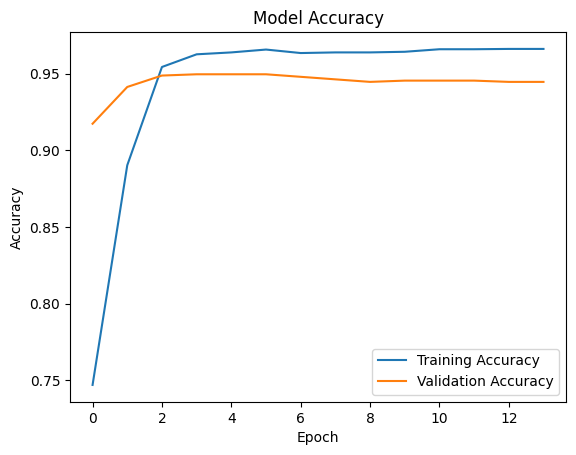

In [63]:
# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_sequences, test_Y)
print('Test Loss :',test_loss)
print('Test Accuracy :',test_accuracy)

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

